In [1]:
## **Importing required Libraries**

In [2]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import tensorflow as tf
print(tf.__version__)


2024-04-17 12:52:24.456068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 12:52:24.456220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 12:52:24.687019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [4]:
import keras
import tensorflow as tf
from tensorflow import keras
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import imageio
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random

#import imutils
#from imutils import paths

%matplotlib inline

In [6]:
from sklearn.metrics import confusion_matrix
import itertools
from pathlib import Path

import tensorflow as tf
from tensorflow import keras




from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

## **Data Ingestion (Image data collection)**

In [7]:
import os
from PIL import Image

def load_images_from_folders(root_dir, image_extensions=['.jpg', '.jpeg', '.png']):
    """
    Load multiple images from multiple folders.

    Parameters:
    root_dir (str): Root directory containing subdirectories with images.
    image_extensions (list): List of image file extensions to consider.

    Returns:
    list: List of PIL Image objects.
    """
    images = []

    # Walk through all directories and subdirectories
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            # Check if the file has a valid image extension
            if any(filename.lower().endswith(ext) for ext in image_extensions):
                # Construct the full path to the image file
                image_path = os.path.join(dirpath, filename)
                try:
                    # Open the image file and append it to the list
                    image = Image.open(image_path)
                    images.append(image)
                except Exception as e:
                    print(f"Error loading image '{image_path}': {e}")

    return images

# Example usage:
# Specify the root directory containing subdirectories with images
root_directory = '/kaggle/input/font-data2/new_data12'

# Load images from the specified root directory
loaded_images = load_images_from_folders(root_directory)

# Print the number of images loaded
print(f"Number of images loaded: {len(loaded_images)}")


Number of images loaded: 18800


In [8]:
# Functions for getting array of directory paths and array of file paths
def get_dir_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]


def get_file_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]

In [9]:
def show_one_image(full_filename):
    img = mpimg.imread(full_filename)
    imgplot = plt.imshow(img)
    plt.show()

In [10]:
# Set image properties
image_size  = 200  # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

##**Image Data Preprocessing**

○Image resizing

○ Image cropping

○ Image denoising

○ Image normalization

In [11]:
import os
from PIL import Image, ImageFilter
import numpy as np

def preprocess_images_in_directory(root_dir, target_size=(224, 224)):
    """
    Preprocess multiple images from different directories.

    Parameters:
    root_dir (str): Root directory containing subdirectories with images.
    target_size (tuple): Target size for resizing the images.

    Returns:
    dict: Dictionary containing preprocessed images as NumPy arrays.
          Keys are directory names, and values are lists of preprocessed images.
    """
    preprocessed_images = {}

    # Walk through all directories and subdirectories
    for dirpath, dirnames, _ in os.walk(root_dir):
        for dirname in dirnames:
            # Get the path to the directory containing images
            image_dir = os.path.join(dirpath, dirname)
            # Initialize a list to store preprocessed images for this directory
            preprocessed_images[dirname] = []

            # Loop through all files in the directory
            for filename in os.listdir(image_dir):
                # Check if the file is an image
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    # Construct the full path to the image file
                    image_path = os.path.join(image_dir, filename)
                    try:
                        # Preprocess the image and append it to the list
                        preprocessed_image = preprocess_image(image_path, target_size)
                        preprocessed_images[dirname].append(preprocessed_image)
                    except Exception as e:
                        print(f"Error preprocessing image '{image_path}': {e}")

    return preprocessed_images

def preprocess_image(image_path, target_size):
    """
    Preprocesses an image.

    Parameters:
    image_path (str): Path to the input image file.
    target_size (tuple): Target size for resizing the image.

    Returns:
    numpy.ndarray: Preprocessed image as a NumPy array.
    """
    # Open the image file
    image = Image.open(image_path)

    # Resize the image to the target size
    image = image.resize(target_size)

    # Crop the image
    image = crop_image(image)

    # Denoise the image
    image = denoise_image(image)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Normalize the pixel values to the range [0, 1]
    image_array = image_array.astype(np.float32) / 255.0

    return image_array



def crop_image(image, crop_size=(200, 200)):
    """
    Crops an image.

    Parameters:
    image (PIL.Image): Input image.
    crop_size (tuple): Size of the cropped region.

    Returns:
    PIL.Image: Cropped image.
    """
    # Crop the image to the specified size
    width, height = image.size
    left = (width - crop_size[0]) // 2
    top = (height - crop_size[1]) // 2
    right = left + crop_size[0]
    bottom = top + crop_size[1]
    cropped_image = image.crop((left, top, right, bottom))

    return cropped_image

def denoise_image(image):
    """
    Denoises an image.

    Parameters:
    image (PIL.Image): Input image.

    Returns:
    PIL.Image: Denoised image.
    """
    # Denoise the image using Gaussian blur
    denoised_image = image.filter(ImageFilter.GaussianBlur(radius=2))

    return denoised_image

# Example usage:
# Specify the root directory containing subdirectories with images
root_directory = '/kaggle/input/font-data2/new_data12'

# Preprocess images from the specified root directory
preprocessed_images = preprocess_images_in_directory(root_directory)




In [12]:
print("no. of fonts: ", len(preprocessed_images))

no. of fonts:  4


In [13]:
for dirname, images in preprocessed_images.items():
    print(f"Directory '{dirname}': {len(images)} preprocessed images")

Directory 'Times New Roman': 4700 preprocessed images
Directory 'Franklin Gothic': 4700 preprocessed images
Directory 'Arial': 4700 preprocessed images
Directory 'Bodoni': 4700 preprocessed images


## **Model data preparation for training**

In [14]:
# Produce clean image data and labels. Also keep the list of font names.
def finalize_image_packaging(all_data, image_size):
    """
    Produce clean image data and labels. Also keep the list of font names.
    """

    images     = []
    labels     = []
    font_names = []

    nb_fonts = len(all_data)

    for label, font_name in enumerate(all_data):
        letter_data = all_data[font_name]

        # All images
        images.extend(letter_data)
        # all labels (integer value)
        labels.extend([label] * len(letter_data))
        # Keep the font names
        font_names.append(font_name)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, font_names

In [15]:
type(preprocessed_images)

dict

In [16]:
import pandas as pd
df = pd.DataFrame(preprocessed_images)

# Display the DataFrame
df.head(1)

,Times New Roman,Franklin Gothic,Arial,Bodoni
0,"[[[0.9098039, 0.9098039, 0.9098039], [0.909803...","[[[0.9254902, 0.9254902, 0.9254902], [0.925490...","[[[0.8980392, 0.8980392, 0.8980392], [0.898039...","[[[0.9137255, 0.9137255, 0.9137255], [0.909803..."


In [17]:
len(df)

4700

In [18]:
import random

# Assuming 'preprocessed_images' is your dataset
#preprocessed_images_list = list(preprocessed_images)
# Take a random sample from the DataFrame
random_preproccesed_sample_df = df.sample(n=2700)

In [19]:
len(random_preproccesed_sample_df)

2700

In [20]:
images, labels, font_names = finalize_image_packaging(random_preproccesed_sample_df, image_size)

In [21]:
images.shape

(10800, 200, 200, 3)

In [22]:
# Show dimensions of datasets and labels
print(f"Images: {images.shape}, labels: {labels.shape}")

Images: (10800, 200, 200, 3), labels: (10800,)


In [23]:
# Show the actual font names (labels) in the dataset
output_labels = font_names

print("Fonts")
for label, font_name in enumerate(output_labels):
    print(f"{label}: {font_name}")

Fonts
0: Times New Roman
1: Franklin Gothic
2: Arial
3: Bodoni


In [24]:
from sklearn.model_selection import train_test_split
X=images
y=labels
nb_fonts = len(output_labels)
images_per_font = X.shape[0] / nb_fonts

# Construct training set and validation set
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Training set
train_X.shape, train_y.shape

((8640, 200, 200, 3), (8640,))

In [26]:
# Validation set
val_X.shape, val_y.shape

((2160, 200, 200, 3), (2160,))

In [27]:
images_per_font

2700.0

In [28]:
# Reshape images to add the channel (height = 50px, width = 50px , channel = 1)
X_train = train_X.reshape(-1, image_size, image_size, 3)
X_val   = val_X.reshape(-1, image_size, image_size, 3)

In [29]:
# Let's see the label's shape before one hot encoding
train_y.shape,val_y.shape

((8640,), (2160,))

In [30]:
# Encode labels to one hot vectors
Y_train = to_categorical(train_y, num_classes = nb_fonts)
Y_val   = to_categorical(val_y,   num_classes = nb_fonts)

In [31]:
X_train.shape,X_val.shape

((8640, 200, 200, 3), (2160, 200, 200, 3))

In [32]:
Y_train.shape,Y_val.shape

((8640, 4), (2160, 4))

##**Define Model**

In [33]:
tf.keras.backend.clear_session()

In [34]:
def get_model_cnn1():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,3))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (5, 5))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(nb_fonts, activation = "softmax")(x)

    model = Model(inputs=input_img, outputs=output)

    return model

In [35]:
# select a model
model = get_model_cnn1()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 200, 200, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 200, 200, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      25632     
                                                                 
 batch_normalization_1 (Bat  (None, 200, 200, 32)      128       
 chNormalization)                                            

##**Compile the Model**

In [36]:
# We do data augmentation to prevent overfitting and adapt better.
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=0,                     # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = [0.9, 1.11],             # Randomly zoom image
        width_shift_range=0.05,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                # randomly flip images
        vertical_flip=False)                  # randomly flip images

In [37]:
# Keras callback to the result of the best epoch in the model
# Intended to work with ModelCheckpoint callback.
class ShowBestEpochResult(tf.keras.callbacks.Callback):
    def __init__(self, on_param='val_loss', show_params=['val_loss', 'loss'], mode='min'):
        self.on_param    = on_param
        self.show_params = show_params
        self.mode        = mode

    def on_train_begin(self, logs=None):
        # The number of epoch at which the best value is found.
        self.best_epoch = 0

        # The best value found for the on_param.
        self.best = np.Inf
        if self.mode == 'max':
            self.best = np.NINF

        # The values on best epoch for each param in show_param.
        self.best_values = {}

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.on_param)
        save_as_best = (self.mode=='min' and current < self.best) or \
                       (self.mode=='max' and current > self.best)

        if save_as_best:
            self.best = current
            for param in self.show_params:
                self.best_values[param] = logs.get(param)
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f"BestEpochResult. Epoch: {self.best_epoch+1},", end=" ")

        for param in self.best_values:
            print(f"{param}: {self.best_values[param]:.5f},", end=" ")
        print(" ")

In [38]:
# Define the optimizer. Adam is generally my best bet.
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')

In [39]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [40]:
# Lower the learning rate if accuracy stops improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=8,
                                            verbose=1,
                                            factor=0.8,
                                            min_delta=1e-7,
                                            min_lr=1e-7)

##**Train the CNN model**

In [41]:
# Fit the model with data Augmentation
# I like to start a few epoch with a small batch size because:
# - This basically makes the learning rate larger. https://openreview.net/pdf?id=B1Yy1BxCZ#:~:text=Increasing%20the%20batch%20size%20during%20training%20achieves%20similar%20results%20to,twice%20to%20illustrate%20the%20variance.
# - This covers to 0 to 80% of the accuracy curve, cleaning the graphs
epochs = 2 # Turn epochs to ...
batch_size = 32
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs=epochs, validation_data = (X_val, Y_val),
                              verbose=1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/2


2024-04-17 12:55:31.023352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1713358543.869307      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


270/270 [==============================] - 183s 570ms/step - loss: 0.2151 - accuracy: 0.9250 - val_loss: 9.0658 - val_accuracy: 0.1921
Epoch 2/2
270/270 [==============================] - 149s 550ms/step - loss: 0.0659 - accuracy: 0.9796 - val_loss: 1.2615 - val_accuracy: 0.8157


In [42]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import Callback

# Define your model and other necessary variables
# Assuming 'model', 'datagen', 'X_train', 'Y_train', 'X_val', 'Y_val', 'learning_rate_reduction', 'ShowBestEpochResult' are defined elsewhere

# Define the filepath for saving the best model
model_checkpoint_path = 'best_model.h5'

checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

best_epoch_results = ShowBestEpochResult(on_param='val_accuracy',
                                         show_params=['val_accuracy', 'accuracy', 'val_loss', 'loss'],
                                         mode='max')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs = 6
batch_size = 60
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(X_val, Y_val),
                    verbose=1, steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=callbacks_list)


Epoch 1/6
144/144 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9922
Epoch 1: val_accuracy improved from -inf to 0.93935, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 188s 1s/step - loss: 0.0288 - accuracy: 0.9922 - val_loss: 0.1341 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 2/6
144/144 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9946
Epoch 2: val_accuracy did not improve from 0.93935
144/144 [==============================] - 148s 1s/step - loss: 0.0214 - accuracy: 0.9946 - val_loss: 0.9133 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 3/6
144/144 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9954
Epoch 3: val_accuracy did not improve from 0.93935
144/144 [==============================] - 148s 1s/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.4218 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 4/6
144/144 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9940
Epoch 4: val_accuracy improved from 0.93935 to 0.97824, saving model to best_model.h5
144/144 [==============================] - 149s 1s/step - loss: 0.0199 - accuracy: 0.9940 - 

## **Performance Evaluation**



### **Plot the loss and accuracy curves for training and validation**

In [43]:
def plot_loss(hist, name, plt):
    loss = hist['loss']
    val_loss = hist['val_loss']

    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [44]:
def plot_accuracy(hist, name, plt):
    loss     = hist['accuracy']
    val_loss = hist['val_accuracy']

    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

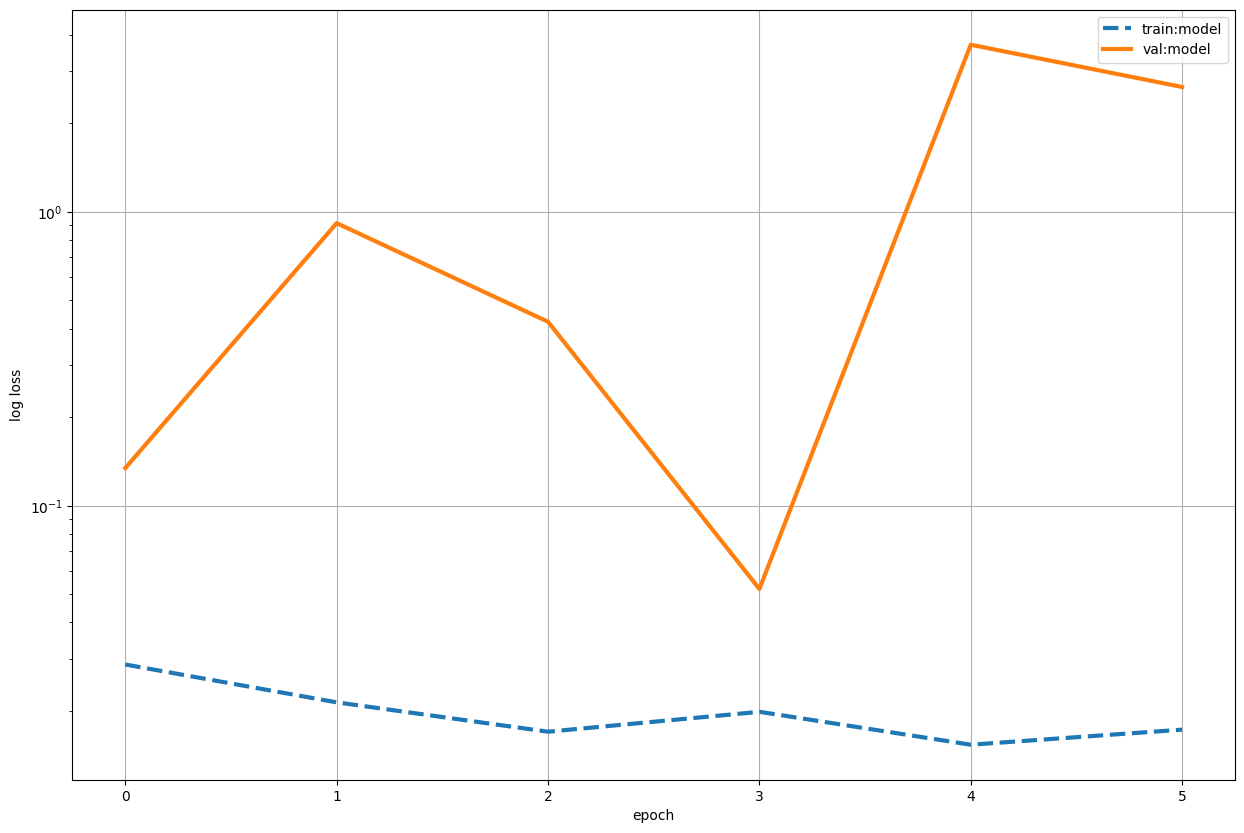

In [45]:
plt.figure(figsize=(15, 10))
plot_loss(history.history, "model", plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

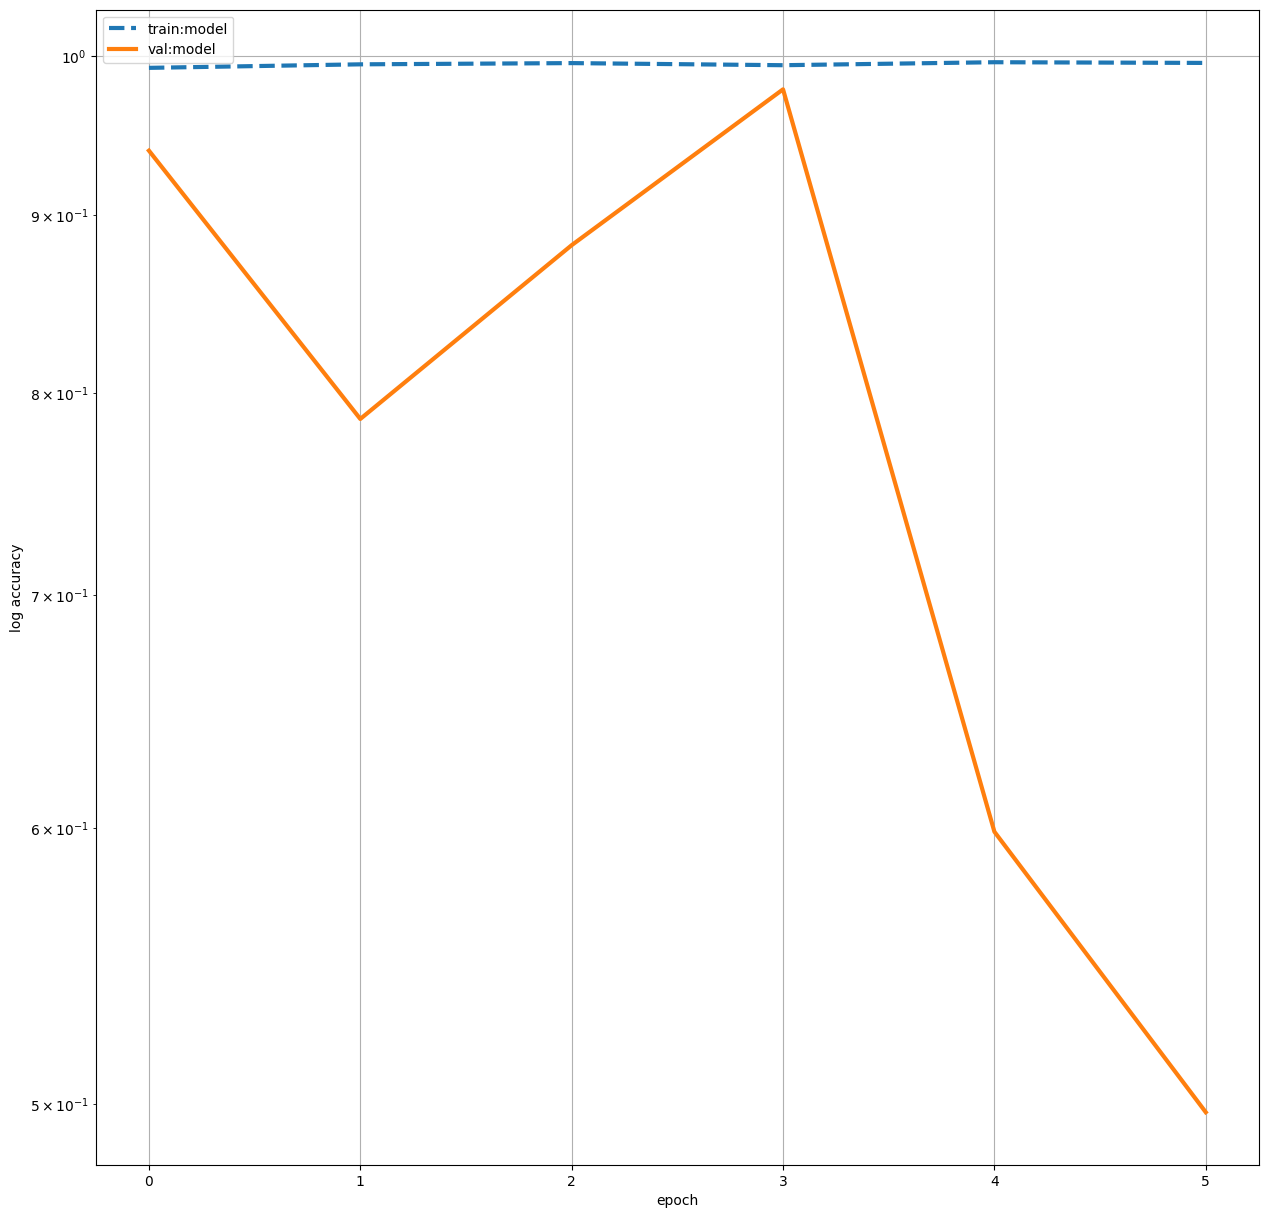

In [46]:
plt.figure(figsize=(15, 15))
plot_accuracy(history.history, "model", plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log accuracy")
plt.show()

###**Delete the existing model + Load best model**

In [51]:
from keras.models import load_model

best_model = load_model("best_model.h5")
best_model.save('final_model.h5')

### **Confusion Matrix**

68/68 [==============================] - 7s 98ms/step


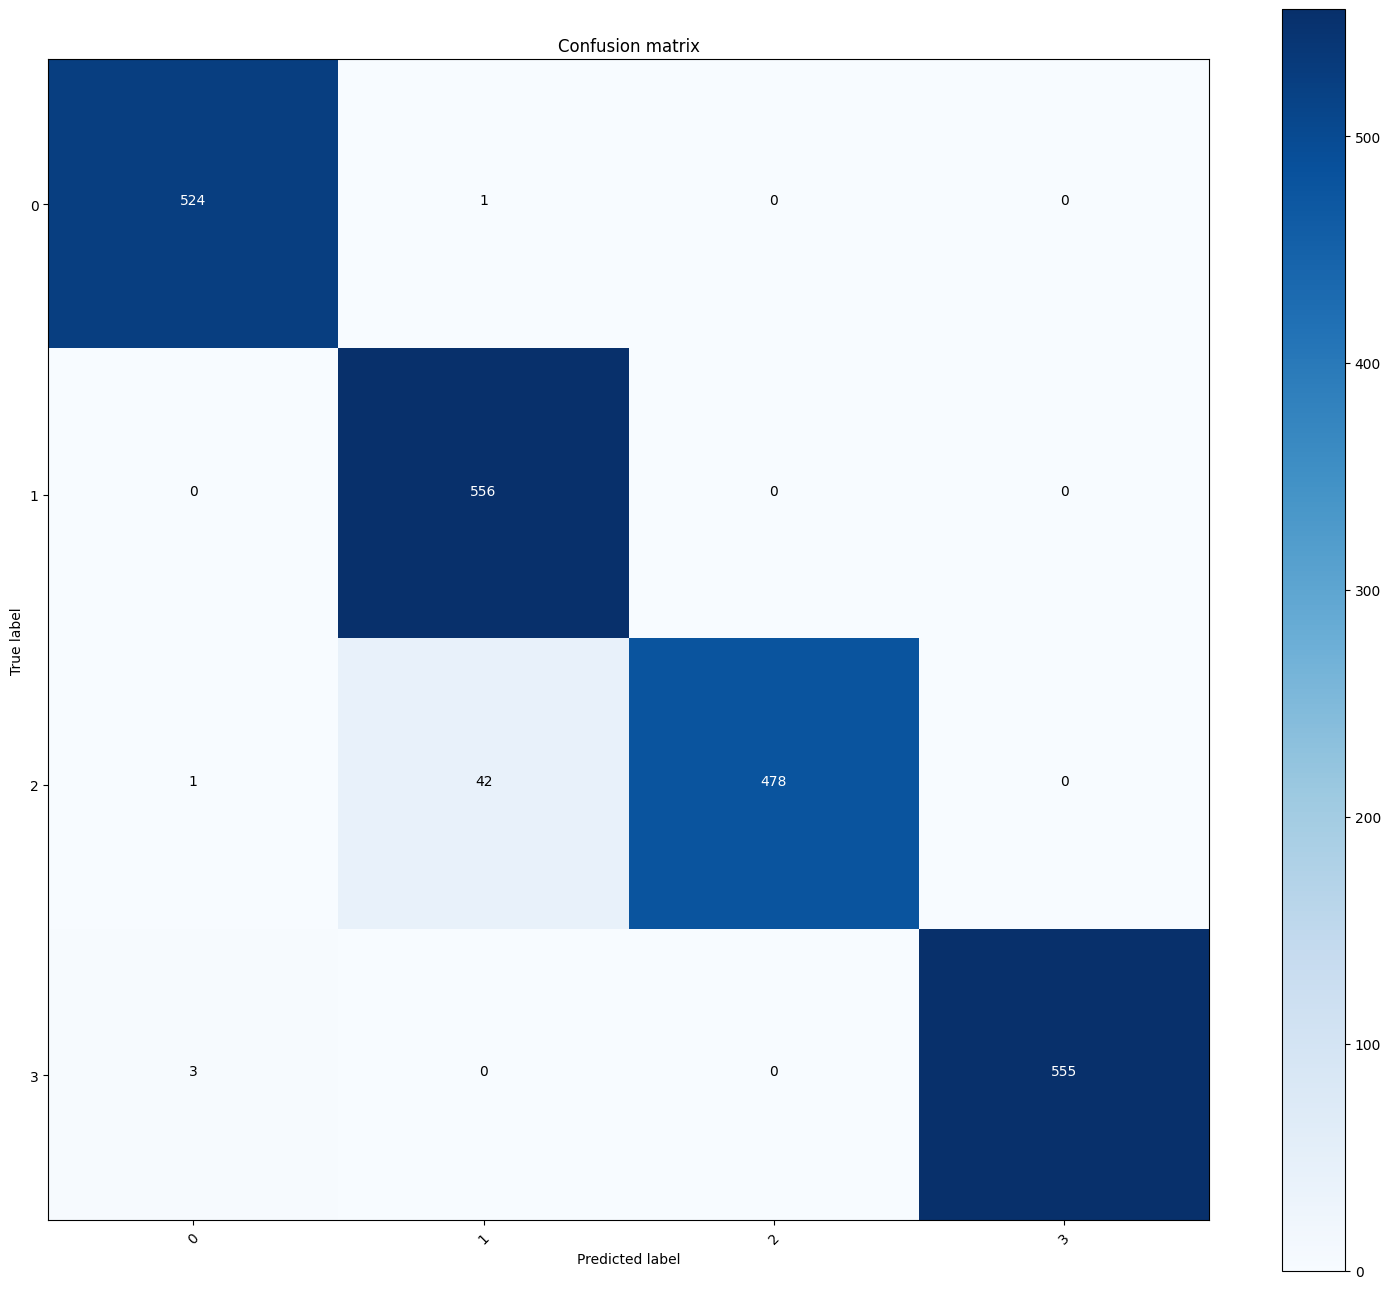

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 13))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = best_model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(nb_fonts))

In [53]:
print("Y_pred shape: ", Y_pred.shape)                 # Prediction for each image in the validaset set
print("Y_pred_classes shape: ", Y_pred_classes.shape) # Index of the font prediction for each image in the val. set
print("Y_true shape: ", Y_true.shape)                 # Index of the actual font for each image in the val. set
print("confusion_mtx shape: ", confusion_mtx.shape)   # Values in the confusion matrix shown above

Y_pred shape:  (2160, 4)
Y_pred_classes shape:  (2160,)
Y_true shape:  (2160,)
confusion_mtx shape:  (4, 4)


In [54]:
Y_pred_classes[0:12]

array([0, 3, 0, 3, 3, 1, 0, 1, 1, 0, 1, 3])

In [55]:
X_val.shape

(2160, 200, 200, 3)

### **Analyze the errors**

In [56]:
# Display some error results

# Errors are difference between predicted labels and true labels. Error[i] is True if this is an error
errors = (Y_pred_classes - Y_true != 0)

# Y_pred_errors: List of Images in the validation set where prediction was bad
X_val_errors = X_val[errors]

# Y_true_errors: Index of the actual font in the validation set where prediction was bad
Y_true_errors = Y_true[errors]

# Y_pred_classes_errors: The list of indexes for font predictions that were bad
Y_pred_classes_errors = Y_pred_classes[errors]

# Y_pred_errors: Prediction for each font in the validation set where prediction was bad
Y_pred_errors = Y_pred[errors]

In [58]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows images with their predicted and real labels"""

    fig = plt.figure(figsize=(13, 15))
    fig.subplots_adjust(hspace=0.13, wspace=0.2, left=0, right=1, bottom=0, top=1)
    nb_pictures = len(errors_index)
    nb_per_row = 5
    nb_of_row  = (nb_pictures - 1) // nb_per_row + 1

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_of_row , nb_per_row, i+1, xticks=[], yticks=[])
        error = errors_index[i]
        plot_sample((img_errors[error]).reshape((image_size,image_size)), ax)
        ax.set_title("Pred: {}\nTrue : {}".format(output_labels[pred_errors[error]], output_labels[obs_errors[error]]))
    plt.show()

### **Show the biggest errors**

In [59]:
import matplotlib.pyplot as plt

def plot_sample(image, ax):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

# Now you can use plot_sample function


In [ ]:
import matplotlib.pyplot as plt

# Define plot_sample function
def plot_sample(image, ax):
    ax.imshow(image, cmap='gray')
    ax.axis('off')

# Display some error results
errors = (Y_pred_classes != Y_true)

# Images in the validation set where prediction was incorrect
X_val_errors = X_val[errors]

# Index of the actual font in the validation set where prediction was incorrect
Y_true_errors = Y_true[errors]

# Indexes of the predicted fonts that were incorrect
Y_pred_classes_errors = Y_pred_classes[errors]

# Predictions for each font in the validation set where prediction was incorrect
Y_pred_errors = Y_pred[errors]

# Display debugging information
print("Validation shape:", errors.shape)
print("X_val_errors shape:", X_val_errors.shape)
print("Y_true_errors shape:", Y_true_errors.shape)
print("Y_pred_classes_errors shape:", Y_pred_classes_errors.shape)
print("Y_pred_errors shape:", Y_pred_errors.shape)


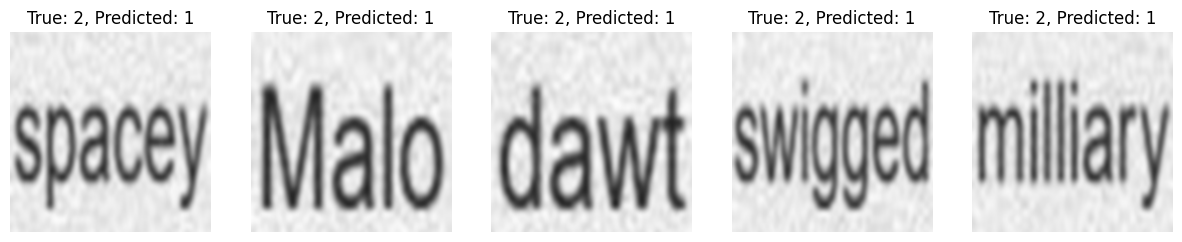

In [60]:
import matplotlib.pyplot as plt

# Define plot_sample function
def plot_sample(image, true_label, pred_label, ax):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'True: {true_label}, Predicted: {pred_label}')
    ax.axis('off')

# Display some error results
num_errors = 5  # Number of error samples to display
fig, axes = plt.subplots(1, num_errors, figsize=(15, 5))

for i in range(num_errors):
    ax = axes[i]
    plot_sample(X_val_errors[i], Y_true_errors[i], Y_pred_classes_errors[i], ax)

plt.show()


In [61]:
# Debugging information
print("Validation shape: ", errors.shape)
print("X_val_errors shape: ", X_val_errors.shape)
print("Y_true_errors shape: ", Y_true_errors.shape)
print("Y_pred_classes_errors shape: ", Y_pred_classes_errors.shape)
print("Y_pred_errors shape: ", Y_pred_errors.shape)

Validation shape:  (2160,)
X_val_errors shape:  (47, 200, 200, 3)
Y_true_errors shape:  (47,)
Y_pred_classes_errors shape:  (47,)
Y_pred_errors shape:  (47, 4)


### **Validation Accuracy**

In [63]:
nb_errors = X_val_errors.shape[0]
nb_val_samples = Y_pred.shape[0]
accuracy = 1.0 - (nb_errors / nb_val_samples)

print("Validation Accuracy:", accuracy)
print(f"Number of errors: {nb_errors} from {nb_val_samples} predictions on validation set.")

Validation Accuracy: 0.9782407407407407
Number of errors: 47 from 2160 predictions on validation set.


##**Save the final Benchmark CNN Model**

In [64]:
import pickle

# Assuming final_benchmark_cnn_model is your trained CNN model
# Save the model to a file
with open('final_benchmark_cnn_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
